# Stock analysis

## Import

Libraries

In [1]:
from functions.init import *

from functions.analyse_price import *
from functions.analyse_fundementals import *
from functions.params import index_tickers

## Get data

Run data

In [2]:
TICKER = 'NVX'
first_end_of_quarter = '2020-06'
last_end_of_quarter = '2024-06'
historical_prices = {}

In [3]:
AU_interest_rate = pd.read_csv(
    '../data/Australia 10-Year Bond Yield Historical Data.csv')

AU_interest_rate['rf'] = AU_interest_rate['Price'].shift(-1)

AU_interest_rate = AU_interest_rate.dropna()
AU_interest_rate = AU_interest_rate[['Date', 'rf']]

AU_interest_rate['Date'] = pd.to_datetime(
    AU_interest_rate['Date'], dayfirst=True)

AU_interest_rate_monthly = AU_interest_rate

AU_interest_rate_quarterly = AU_interest_rate[AU_interest_rate['Date'].dt.month.isin([
                                                                                     1, 4, 7, 10])]
AU_interest_rate_annualy = AU_interest_rate[AU_interest_rate['Date'].dt.month.isin([
                                                                                   1])]

AU_interest_rate_monthly = AU_interest_rate_monthly.set_index('Date')
AU_interest_rate_quarterly = AU_interest_rate_quarterly.set_index('Date')
AU_interest_rate_annualy = AU_interest_rate_annualy.set_index('Date')

In [4]:
asx_companies_directory = pd.read_csv('../data/asx_companies_directory.csv')
asx_companies_directory['Market Cap'] = asx_companies_directory['Market Cap'].apply(
    lambda x: float(x) if x.isnumeric() else float(x.lower()) if 'E+' in x else np.nan)

In [5]:
gics = pd.read_csv('../data/asx_gics.csv')

# Define a dictionary mapping tickers to their corresponding sector and industry
updates = {
    'NWSLV.AX': {'Sector': 'Communication Services', 'Industry': 'Entertainment'},
    'KKC.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'PCI.AX': {'Sector': 'Financials', 'Industry': 'Diversified Financials'},
    'RF1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'RG8.AX': {'Sector': 'Information Technology', 'Industry': 'Software'},
    'VG1.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'},
    'WQG.AX': {'Sector': 'Financials', 'Industry': 'Investment Management'}
}

# Update the DataFrame based on the mapping
for ticker, data in updates.items():
    gics.loc[gics['Ticker'] == ticker, 'Sector'] = data['Sector']
    gics.loc[gics['Ticker'] == ticker, 'Industry'] = data['Industry']


gics['Industry'] = gics['Industry'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

gics['Sector'] = gics['Sector'].apply(lambda x: ''.join(
    str(x).split('-')).replace(' ', '').replace('—', ''))

In [6]:
# all companies in the top 500
top_500 = asx_companies_directory.sort_values(
    'Market Cap', ascending=False).head(500)['ASX code'].values + '.AX'

# get all companies with market cap above 1 billion
above_1b = asx_companies_directory[asx_companies_directory['Market Cap']
                                   >= 1000000000]['ASX code'].values + '.AX'

In [7]:
def find_similar_type_tickers(gics_type: str, gics_name: str, comparable_universe: list) -> list:
    same_gics_tickers = gics[(gics[gics_type] == gics_name) & (
        gics['Ticker'].isin(comparable_universe))]['Ticker'].values

    return same_gics_tickers

In [8]:
# find same industry stocks
ticker_gics_sector = gics[gics['Ticker'] == f'{TICKER}.AX']['Sector'].values[0]
ticker_gics_industry = gics[gics['Ticker']
                            == f'{TICKER}.AX']['Industry'].values[0]

In [9]:
same_sector_1bn = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=above_1b)
same_industry_1bn = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=above_1b)
same_sector_500 = find_similar_type_tickers(
    gics_type='Sector', gics_name=ticker_gics_sector, comparable_universe=top_500)
same_industry_500 = find_similar_type_tickers(
    gics_type='Industry', gics_name=ticker_gics_industry, comparable_universe=top_500)

In [10]:
comparable_tickers = {'type': 'same_industry_500', 'list': same_industry_500} if \
    (len(same_industry_500) > 1 or len(same_industry_500) == 1 and f'{TICKER}.AX' not in same_industry_500) \
    else {'type': 'same_sector_1bn', 'list': same_sector_1bn}

In [11]:
comparable_tickers['type']

'same_sector_1bn'

In [12]:
# get market caps and weight
same_industry_tickers_mcap = asx_companies_directory[((asx_companies_directory['ASX code']+'.AX').isin(
    comparable_tickers['list'])) & (asx_companies_directory['ASX code'] != TICKER)][['ASX code', 'Market Cap']]

# check for is integer
marketsame_industry_tickers_mcap_cap = same_industry_tickers_mcap[same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: isinstance(x, float))]

# get weight
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['Market Cap'] / \
    same_industry_tickers_mcap['Market Cap'].sum()

In [13]:
same_industry_tickers_mcap = same_industry_tickers_mcap.sort_values(
    by='Market Cap', ascending=False)
display(same_industry_tickers_mcap)

ticker_mv = asx_companies_directory[asx_companies_directory['ASX code'] == TICKER][[
    'ASX code', 'Market Cap']]
display(ticker_mv)

ticker_proportion_of_market = ticker_mv['Market Cap'].values[0] / \
    same_industry_tickers_mcap['Market Cap'].sum()
print(round(ticker_proportion_of_market, 2))

,ASX code,Market Cap,weight
1723,TCL,4.093633e+10,0.204927
358,BXB,2.640665e+10,0.132192
1493,REH,1.786792e+10,0.089447
1699,SVW,1.746022e+10,0.087406
96,AIA,1.117357e+10,0.055935
1454,QAN,1.089885e+10,0.054560
909,IFT,1.070929e+10,0.053611
123,ALX,7.007527e+09,0.035080
120,ALQ,6.919700e+09,0.034640
1464,QUB,6.914100e+09,0.034612


,ASX code,Market Cap
1274,NVX,357968369.0


0.0


In [14]:
ticker_mv['Market Cap'] = ticker_mv['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
ticker_mv.rename(columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)

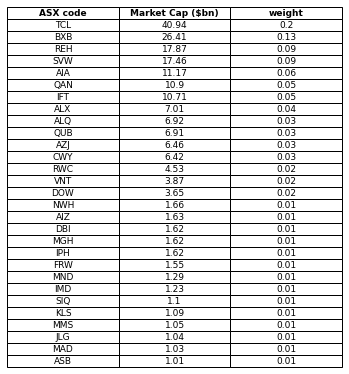

In [15]:
# Create the plot
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

same_industry_tickers_mcap['Market Cap'] = same_industry_tickers_mcap['Market Cap'].apply(
    lambda x: round(x/1e9, 2))
same_industry_tickers_mcap.rename(
    columns={'Market Cap': 'Market Cap ($bn)'}, inplace=True)
same_industry_tickers_mcap['weight'] = same_industry_tickers_mcap['weight'].apply(
    lambda x: round(x, 2))


# Create a table in the plot
table = ax.table(cellText=same_industry_tickers_mcap.values,
                 colLabels=same_industry_tickers_mcap.columns,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')


# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [16]:
same_gics_industry_weight_dict = same_industry_tickers_mcap.set_index('ASX code')[
    'weight'].to_dict()

In [17]:
my_portfolio_tickers = [TICKER]
my_portfolio_tickers.extend([ticker.split('.')[
                            0] for ticker in comparable_tickers['list'] if ticker.split('.')[0] != TICKER])
my_portfolio_tickers.extend(index_tickers)

historical_prices = get_historical_prices(
    my_portfolio_tickers, index_tickers, historical_prices)

$DBI.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2020-01-01 -> 2020-12-31) (Yahoo error = "Data doesn't exist for startDate = 1577797200, endDate = 1609333200")
$MGH.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: possibly delisted; no price data found  (1d 2021-01-01 -> 2021-12-31) (Yahoo error = "Data doesn't exist for startDate = 1609419600, endDate = 1640869200")
$VNT.AX: possibly delisted; no price data found  (1d 2019-06-01 -> 2019-12-31) (Yahoo error = "Data doesn't exist for startDate = 1559311200, endDate = 1577710800")
$FRW.AX: p

In [18]:
monthly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    monthly_returns_df_dict[ticker] = get_return(
        price_df, AU_interest_rate_monthly, 'M')

quarterly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    quarterly_returns_df_dict[ticker] = get_return(
        price_df, AU_interest_rate_quarterly, 'Q')

yearly_returns_df_dict = {}
for ticker, price_df in historical_prices.items():
    yearly_returns_df_dict[ticker] = get_return(
        price_df, AU_interest_rate_annualy, 'Y')

In [34]:
monthly_returns_df_dict = get_gics_industry_weighted_mean(
    monthly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'M', comparable_tickers=comparable_tickers)
quarterly_returns_df_dict = get_gics_industry_weighted_mean(
    quarterly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Q', comparable_tickers=comparable_tickers)
yearly_returns_df_dict = get_gics_industry_weighted_mean(
    yearly_returns_df_dict, TICKER, my_portfolio_tickers, same_gics_industry_weight_dict, index_tickers, 'Y', comparable_tickers=comparable_tickers)

In [78]:
def get_stats(returns_df_dict: str, ticker: str, start_period: str, end_year: str):

    SHARPE_MULTIPLIER = 12

    period_of_interest_return_df = returns_df_dict[ticker].loc[start_period:end_year]

    stats_dict = {}

    # mean, std, n
    stats_dict["mean (%)"] = np.round(
        period_of_interest_return_df['M_Return (%)'].mean(), 2)
    stats_dict["std (%)"] = np.round(
        period_of_interest_return_df['M_Return (%)'].std(), 2)

    stats_dict['mean (-rf) (%)'] = np.round(
        period_of_interest_return_df['M_Return - rf (%)'].mean(), 2)

    # sharpe
    stats_dict["n"] = period_of_interest_return_df[
        ~period_of_interest_return_df[f"M_Return (%)"].isna()
    ].shape[0]
    stats_dict["sharpe"] = np.round(
        np.sqrt(SHARPE_MULTIPLIER) *
        stats_dict["mean (-rf) (%)"] / stats_dict["std (%)"], 2
    )

    # earliest and latest date for ticker
    regression_start_period = returns_df_dict[ticker].index[1]
    regression_end_period = returns_df_dict[ticker].index[-1]

    # beta over this period
    X = returns_df_dict["^AORD"].loc[regression_start_period:regression_end_period][
        f"M_Return - rf (%)"
    ]
    y = returns_df_dict[ticker].loc[regression_start_period:regression_end_period][
        f"M_Return - rf (%)"
    ]
    y.rename(f"{ticker}_M_Return - rf (%)", inplace=True)
    X_y = pd.concat([X, y], axis=1)

    X_y.dropna(inplace=True)
    X = X_y[[X_y.columns[0]]]
    y = X_y[X_y.columns[1]]

    X = sm.add_constant(X)

    linreg = sm.OLS(y, X).fit()
    stats_dict["CAPM beta"] = np.round(linreg.params[f"M_Return - rf (%)"], 2)
    stats_dict["CAPM alpha"] = np.round(linreg.params["const"], 2)

    return stats_dict

In [79]:
get_stats(monthly_returns_df_dict, TICKER,
          first_end_of_quarter, last_end_of_quarter)

{'mean (%)': 5.67,
 'std (%)': 34.51,
 'mean (-rf) (%)': 2.95,
 'n': 49,
 'sharpe': 0.3,
 'CAPM beta': 2.78,
 'CAPM alpha': 8.77}

In [62]:
stats_dict = {}

for ticker in monthly_returns_df_dict:
    stats_dict[ticker] = get_stats(
        monthly_returns_df_dict, ticker, first_end_of_quarter, last_end_of_quarter)

stats_df = pd.DataFrame(stats_dict).T

In [63]:
same_gics_stats_df = stats_df[~stats_df.index.isin(
    index_tickers + [TICKER, 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean'])]

In [64]:
same_gics_stats_df['ASX code'] = same_gics_stats_df.index

same_gics_stats_df = same_gics_stats_df.merge(
    same_industry_tickers_mcap, on='ASX code')

In [65]:
# get weighted means of each column
weighted_mean_dict = {}
for col in same_gics_stats_df.columns:
    if col in ['ASX code', 'weight']:
        continue
    weighted_mean_dict[col] = np.average(
        same_gics_stats_df[col], weights=same_gics_stats_df['weight'])

weighted_mean_df = pd.DataFrame(weighted_mean_dict, index=[
                                'GICS I.WMean (Macro)' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean (Macro)'])
weighted_mean_df

stats_df = pd.concat(
    [stats_df, weighted_mean_df.drop(columns=['Market Cap ($bn)'])])
stats_df

,mean (%),std (%),mean - rf (%),n,sharpe,CAPM beta,CAPM alpha
NVX,5.670000,34.510000,2.950000,49.000000,0.300000,2.780000,8.77000
AIA,0.480000,5.200000,-2.250000,49.000000,-1.500000,1.050000,-0.62000
AIZ,-0.450000,8.370000,-3.170000,49.000000,-1.310000,1.810000,0.57000
ALQ,1.950000,8.220000,-0.780000,49.000000,-0.330000,1.450000,2.10000
ALX,0.230000,5.800000,-2.500000,49.000000,-1.490000,0.890000,-0.58000
ASB,0.200000,11.000000,-2.530000,49.000000,-0.800000,0.770000,-0.27000
AZJ,0.080000,5.460000,-2.650000,49.000000,-1.680000,0.670000,-1.23000
BXB,0.840000,5.750000,-1.890000,49.000000,-1.140000,0.620000,-0.25000
CWY,1.220000,8.670000,-1.510000,49.000000,-0.600000,1.180000,0.76000
DBI,1.540000,4.220000,-1.500000,42.000000,-1.230000,0.440000,-0.27000


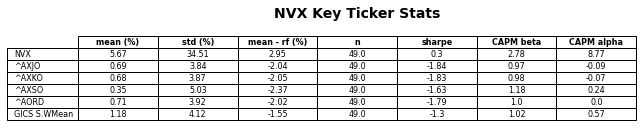

In [68]:
# Assuming key_ticker_stats is already created from your DataFrame
key_ticker_stats = stats_df.loc[[TICKER, '^AXJO',
                                 '^AXKO', '^AXSO', '^AORD'] + ['GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean']]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=key_ticker_stats.values,
                 colLabels=key_ticker_stats.columns,
                 rowLabels=key_ticker_stats.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=14, fontweight='bold')

# Save the plot as an image
plt.savefig(
    f'../outputs/{TICKER}_key_ticker_stats_table.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [69]:
ticker_mv['Market Cap ($bn)'].values[0] / \
    weighted_mean_df['Market Cap ($bn)'].values[0]

0.020531788834870817

In [85]:
correlation_df, period_of_interest_return_df = historical_corr(
    monthly_returns_df_dict, first_end_of_quarter, last_end_of_quarter)

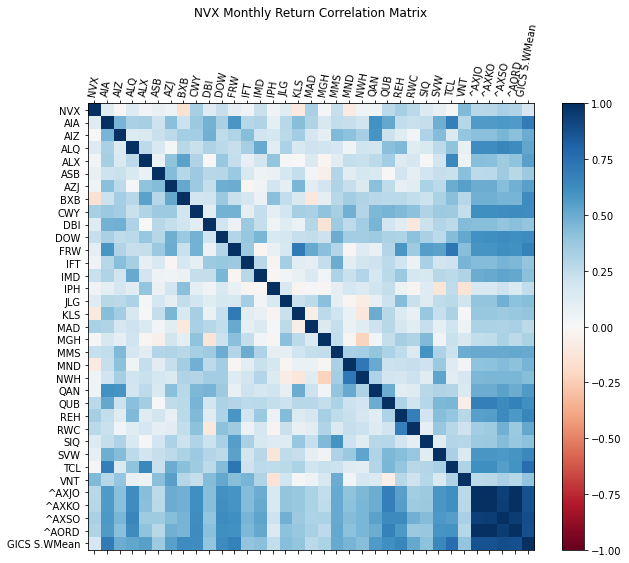

In [86]:
plot_correlation(correlation_df, ticker=TICKER)

In [88]:
monthly_returns_df_dict[TICKER]

,M_Return (%),rf,M_Return - rf (%)
Date,,,
2019-06,NaN,1.476,NaN
2019-07,19.318147,1.319,17.999147
2019-08,4.762061,1.203,3.559061
2019-09,-10.000172,0.892,-10.892172
2019-10,19.192189,0.970,18.222189
...,...,...,...
2024-06,2.898548,4.399,-1.500452
2024-07,4.929581,4.351,0.578581
2024-08,-17.449664,4.116,-21.565664


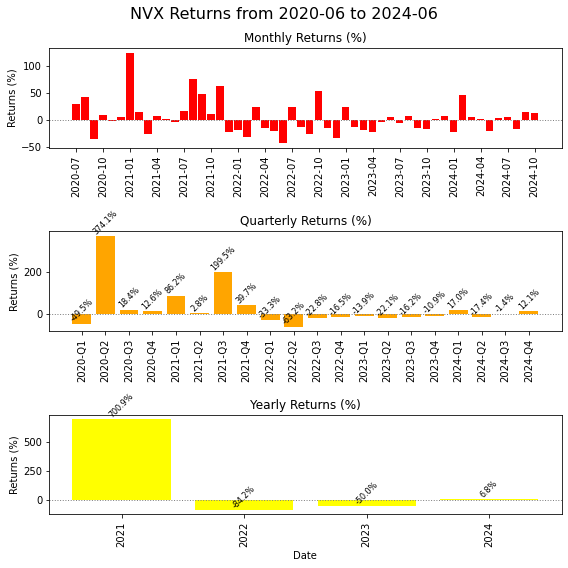

In [90]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': TICKER,
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

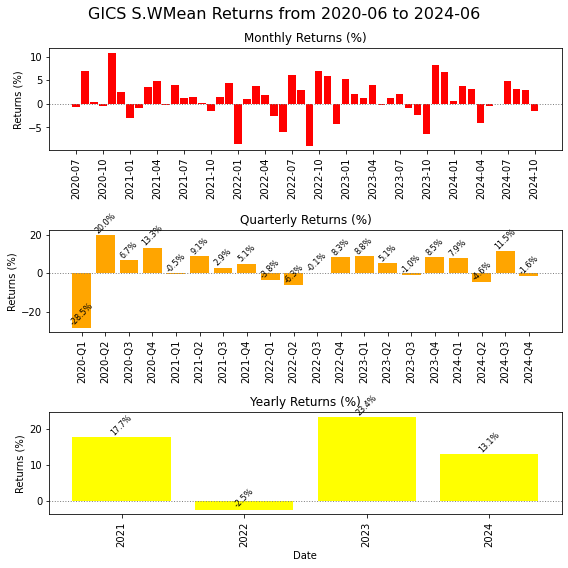

In [91]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict,
                'ticker': 'GICS I.WMean' if 'industry' in comparable_tickers['type'] else 'GICS S.WMean',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter,
                'underlying_ticker': TICKER})

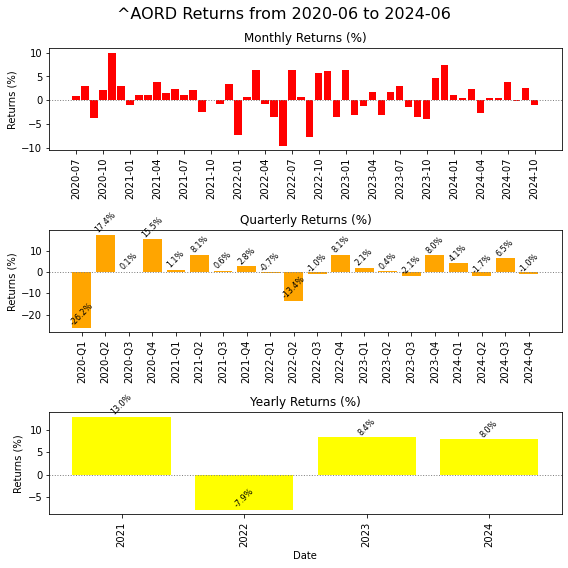

In [92]:
plot_returns(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                'quarterly_returns_df_dict': quarterly_returns_df_dict,
                'yearly_returns_df_dict': yearly_returns_df_dict, 'ticker': '^AORD',
                'first_end_of_quarter': first_end_of_quarter,
                'last_end_of_quarter': last_end_of_quarter})

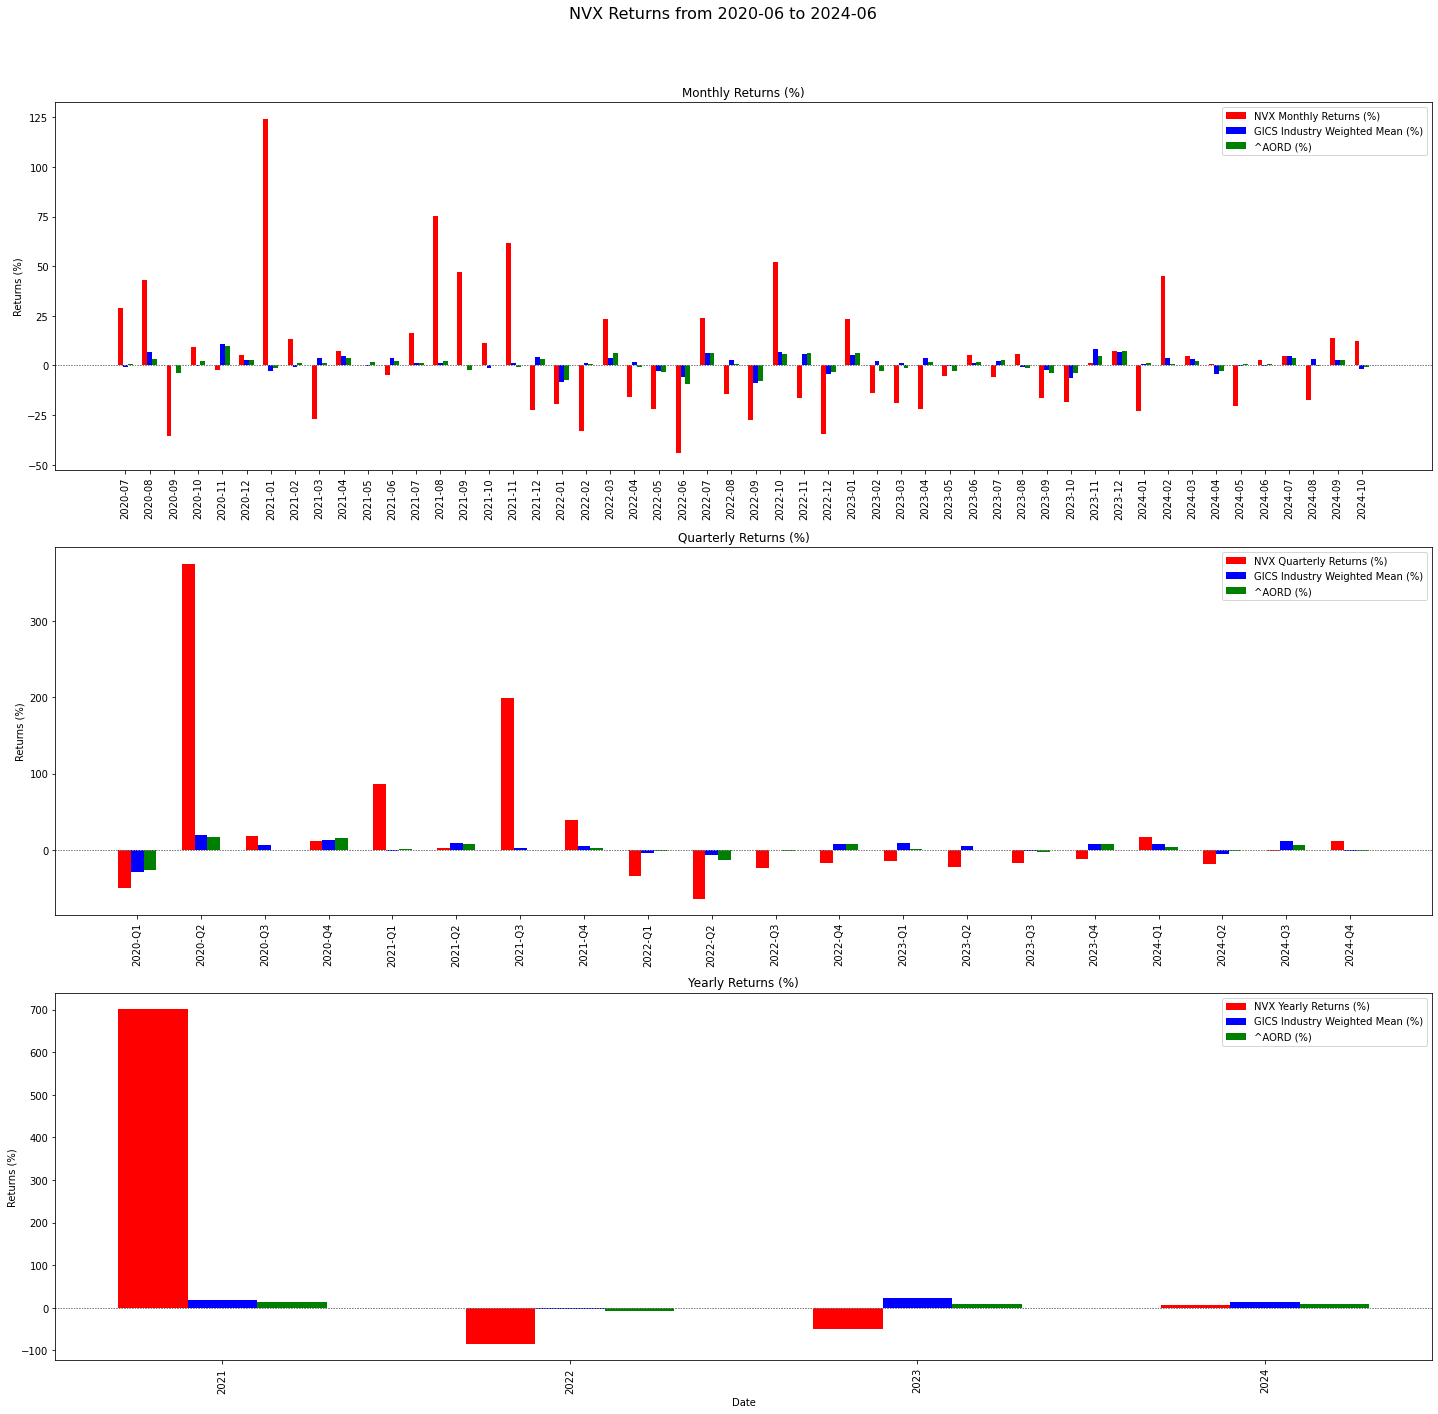

In [96]:
plot_returns_comparative(**{'monthly_returns_df_dict': monthly_returns_df_dict,
                            'quarterly_returns_df_dict': quarterly_returns_df_dict,
                            'yearly_returns_df_dict': yearly_returns_df_dict, 'TICKER': TICKER,
                            'first_end_of_quarter': first_end_of_quarter,
                            'last_end_of_quarter': last_end_of_quarter,
                            'comparable_tickers': comparable_tickers})

In [ ]:
plot_close_price_with_dollar_lines(TICKER, historical_prices)

In [73]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()

# Ensure the 'Date' column is in datetime format
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])

# Convert the 'Date' column to AEST
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_dividends[historical_dividends['Dividends'] > 0][[
        'Date', 'Dividends']])

,Date,Dividends


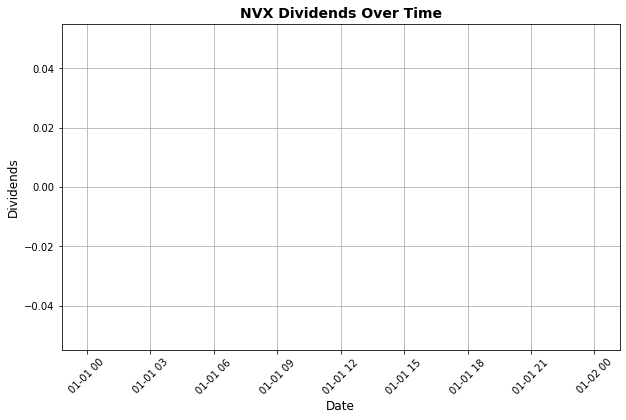

In [74]:
# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]
# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends
ax.plot(dividends_df['Date'], dividends_df['Dividends'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Dividends Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Dividends', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_dividends_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

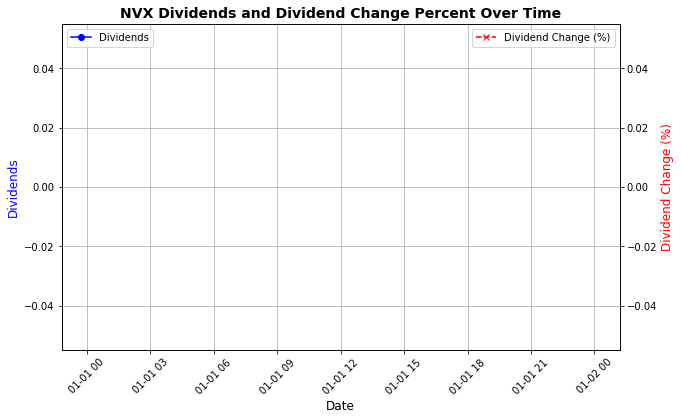

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming historical_dividends is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_dividends = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_dividends = historical_dividends.reset_index()
historical_dividends['Date'] = pd.to_datetime(historical_dividends['Date'])
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_convert(
    'Australia/Sydney')
historical_dividends['Date'] = historical_dividends['Date'].dt.tz_localize(
    None)

# Filter the data to include only the rows where Dividends are greater than 0
dividends_df = historical_dividends[historical_dividends['Dividends'] > 0][[
    'Date', 'Dividends']]

# Calculate the percentage change in dividends
dividends_df['Dividend Change (%)'] = dividends_df['Dividends'].pct_change(
) * 100

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Dividends on the primary y-axis
ax1.plot(dividends_df['Date'], dividends_df['Dividends'],
         marker='o', linestyle='-', color='b', label='Dividends')

# Set the title and labels for the primary y-axis
ax1.set_title(f'{TICKER} Dividends and Dividend Change Percent Over Time',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Dividends', fontsize=12, color='b')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax1.grid(True)

# Create a secondary y-axis to plot the dividend change percentage
ax2 = ax1.twinx()

# Plot Date vs Dividend Change (%) on the secondary y-axis
ax2.plot(dividends_df['Date'], dividends_df['Dividend Change (%)'],
         marker='x', linestyle='--', color='r', label='Dividend Change (%)')

# Set the labels for the secondary y-axis
ax2.set_ylabel('Dividend Change (%)', fontsize=12, color='r')

# Add legends to distinguish between the two y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Annotate the percentage change values on the plot
for i, (date, change) in dividends_df[['Date', 'Dividend Change (%)']].dropna().iterrows():
    ax2.annotate(f'{change:.1f}%', xy=(date, change), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='r')

# Save the plot as an image if needed
plt.savefig(
    f'../outputs/{TICKER}_dividends_and_change_over_time.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [76]:
# Convert date to AEST directly using tz_convert, since the index is already timezone-aware
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(
    None)

# Display the dividends greater than 0 with the adjusted 'Date' column
display(historical_splits[historical_splits['Stock Splits'] > 0][[
        'Date', 'Stock Splits']])

,Date,Stock Splits


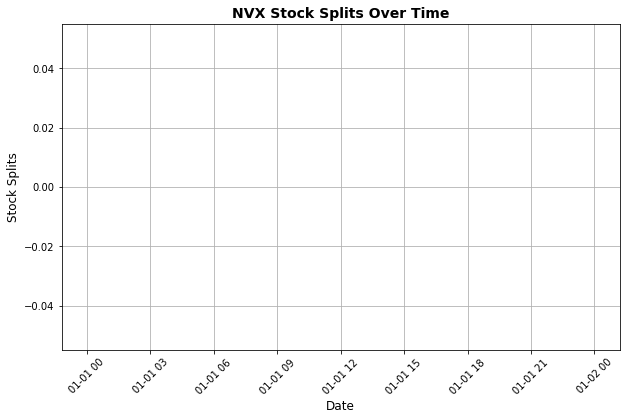

In [77]:
# Assuming historical_splits is your DataFrame for a specific TICKER
# Convert the date to AEST
historical_splits = historical_prices[TICKER]

# Reset index to move 'Date' from index to a column
historical_splits = historical_splits.reset_index()

# Ensure the 'Date' column is in datetime format
historical_splits['Date'] = pd.to_datetime(historical_splits['Date'])

# Convert the 'Date' column to AEST
historical_splits['Date'] = historical_splits['Date'].dt.tz_convert(
    'Australia/Sydney')

# Now make it timezone-unaware but still a timestamp
historical_splits['Date'] = historical_splits['Date'].dt.tz_localize(None)

# Filter the data to include only the rows where Stock Splits are greater than 0
splits_df = historical_splits[historical_splits['Stock Splits'] > 0][[
    'Date', 'Stock Splits']]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))  # Create a plot with a defined size

# Plot Date vs Stock Splits
ax.plot(splits_df['Date'], splits_df['Stock Splits'],
        marker='o', linestyle='-', color='b')

# Set the title and labels
ax.set_title(f'{TICKER} Stock Splits Over Time',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Stock Splits', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True)

# Save the plot as an image if needed
plt.savefig(f'../outputs/{TICKER}_stock_splits_over_time.png',
            bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [37]:
# pdf = FPDF()

# # TITLE
# # Add a page
# pdf.add_page()
# # Set font for the title
# pdf.set_font("Arial", 'B', 16)  # Bold and size 16 for the title
# title = f"Stock Analysis of Ticker: {TICKER}"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # Comparable Ticker Universe
# # Set font for the content
# pdf.set_font("Arial", 'B', size=12)
# pdf.cell(200, 10, txt=f"Comparable tickers universe", ln=True, align='L')
# pdf.set_font("Arial", size=10)
# text = f"{'same INDUSTRY of TOP500' if 'industry' in comparable_tickers['type'] else 'same SECTOR of MCAP$1BN+'}"
# pdf.cell(200, 10, txt=text, ln=True, align='L')

# # Retrieve and convert the Market Cap of the stock in question (from ticker_mv) to billions
# ticker_market_cap_billion = round(
#     ticker_mv.iloc[0]['Market Cap ($bn)'], 2)
# ticker_proportion_of_market = ticker_mv['Market Cap ($bn)'].values[0] / \
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum()
# universe_market_value_billion = round(
#     same_industry_tickers_mcap['Market Cap ($bn)'].sum(), 2)
# pdf.cell(
#     200, 10, txt=f"{TICKER} has a market value of ${ticker_market_cap_billion}B and is {round(ticker_proportion_of_market, 2)} times the universe market value of ${universe_market_value_billion}B,", align='L')
# pdf.cell(
#     200, 10, txt=f"{round(ticker_mv['Market Cap ($bn)'].values[0]/weighted_mean_df['Market Cap ($bn)'].values[0],2)} times the average stock MCap in the universe.", align='L')
# pdf.ln()

# # KEY STATS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Key Stats", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_key_ticker_stats_table.png', x=10, y=None, w=125)

# # COMPARATIVE RETURNS PLOTS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Comparative Returns Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_comparative_returns.png', x=10, y=None, w=150)

# # TICKER RETURN CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_returns.png', x=10, y=None, w=100)

# # SECTOR/INDUSTRY WMEAN RETURNS CHART
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Weighted Mean Returns Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_WMean_returns.png', x=10, y=None, w=100)

# # ^AORD CHART
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(
#     200, 10, txt=f"{TICKER} ^AORD Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/^AORD_returns.png', x=10, y=None, w=100)

# # CLOSE PRICE CHART
# pdf.add_page()  # Add a new page for the plot
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Close Price Chart", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_close_price.png', x=10, y=None, w=75)

# # DIVIDENDS
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(200, 10, txt=f"{TICKER} Dividends", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_dividends_over_time.png', x=10, y=None, w=75)

# # APPENDIX
# pdf.add_page()  # Add a new page for the appendix
# # Set font for the title
# pdf.set_font("Arial", 'B', 12)  # Bold and size 16 for the title

# # APPENDIX TITLE
# title = f"Appendix"
# pdf.cell(200, 10, txt=title, ln=True, align='C')

# # CORRELATION
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Correlation Matrix Plot", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(f'../outputs/{TICKER}_correlation_matrix.png', x=10, y=None, w=140)

# # SPLITS
# pdf.set_font("Arial", 'B', 12)
# pdf.cell(200, 10, txt=f"{TICKER} Splits", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_stock_splits_over_time.png', x=10, y=None, w=75)

# # INDUSTRY TICKER MCAP TABLE
# pdf.add_page()
# pdf.set_font("Arial", 'B', 12)  # Optional: Add a title before the image
# pdf.cell(
#     200, 10, txt=f"{TICKER} Same {'Industry' if 'industry' in comparable_tickers['type'] else 'Sector'} Ticker MCAP Table", ln=True, align='L')
# pdf.ln(5)  # Line break before adding the image
# pdf.image(
#     f'../outputs/{TICKER}_same_industry_tickers_mcap_table.png', x=10, y=None, w=75)

# # Save the PDF after adding the image
# pdf.output(f"../reports/{TICKER}_comparable_tickers_report_with_plot.pdf")

# Other Stats

In [ ]:
interested_ticker_raw_stats, interested_ticker_key_interested_stats, interested_ticker_key_interested_stats_pct_change = get_fundemental_dfs(first_end_of_quarter, historical_prices, TICKER)

In [ ]:
interested_ticker_raw_stats

In [ ]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_raw_stats.T.values,
                 colLabels=interested_ticker_raw_stats.T.columns,
                 rowLabels=interested_ticker_raw_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_interested_ticker_raw_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [ ]:
interested_ticker_key_interested_stats

In [ ]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats.T.values,
                 colLabels=interested_ticker_key_interested_stats.T.columns,
                 rowLabels=interested_ticker_key_interested_stats.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_interested_ticker_key_interested_stats.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [ ]:
interested_ticker_key_interested_stats_pct_change

In [ ]:
# Create the plot for the table
fig, ax = plt.subplots(figsize=(10, 3))  # Adjust the figure size as needed
ax.axis('tight')
ax.axis('off')

# Create a table in the plot
table = ax.table(cellText=interested_ticker_key_interested_stats_pct_change.T.values,
                 colLabels=interested_ticker_key_interested_stats_pct_change.T.columns,
                 rowLabels=interested_ticker_key_interested_stats_pct_change.T.index,
                 cellLoc='center', loc='center')

# Bold the header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # This selects the header row
        cell.set_text_props(fontweight='bold')

# Set the title with bold font
plt.title(f"{TICKER} Key Ticker Stats", fontsize=16, fontweight='bold')

# Save the plot as an image
plt.savefig(f'../outputs/{TICKER}_interested_ticker_key_interested_stats_pct_change.png', bbox_inches='tight', dpi=300)

# Optionally display the plot
plt.show()

In [ ]:
key_interested_stats_pct_change_list = dict()

for ticker in tqdm(comparable_tickers['list']):
    ticker = ticker.split('.')[0]
    raw_stats, key_interested_stats, key_interested_stats_pct_change = get_fundemental_dfs(
        first_end_of_quarter, historical_prices, ticker)
    
    key_interested_stats_pct_change_list[ticker] = key_interested_stats_pct_change

In [ ]:
for key in key_interested_stats_pct_change_list:
    print(key)
    display(key_interested_stats_pct_change_list[key])